In [28]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf
import random
import seaborn

## Optional:
 Set plot style and print of pandas df

In [16]:
# OPTIONAL:
# set plot style and print of pandas df
plt.style.use("seaborn-v0_8")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
np.set_printoptions(threshold=1000)

## Asset and Data Acquisition Section
Obtain market data for investment analysis. In this guide, we use the S&P 500, a benchmark for quality investments.
Note that the market does not operate every day of the year; the number of trading days varies by asset.
To proceed, download the annual returns of the selected financial instrument, adjusting for the specific number of market days in a year if you choose an asset other than the S&P 500.


[*********************100%%**********************]  1 of 1 completed


<Axes: xlabel='Date'>

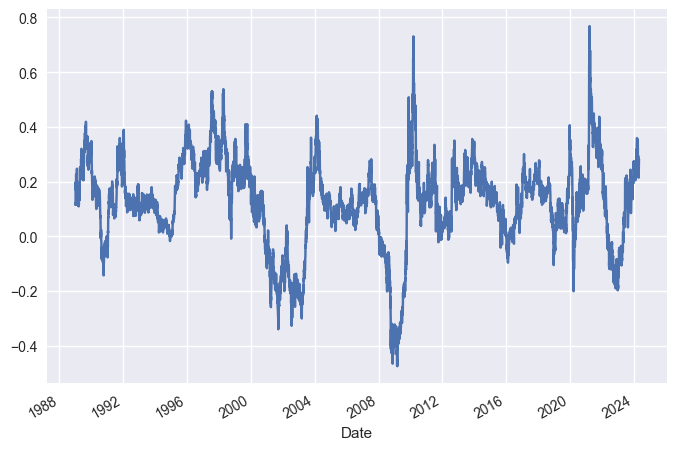

In [17]:
# ASSET AND DATA ACQUISITION SECTION
# Obtain market data for investment analysis. In this guide, we use the S&P 500, a benchmark for quality investments.
# Note that the market does not operate every day of the year; the number of trading days varies by asset.
# To proceed, download the annual returns of the selected financial instrument, adjusting for the specific number of
# market days in a year if you choose an asset other than the S&P 500.
asset = "^SP500TR"
year_market_days = 253
df = yf.download(asset)["Adj Close"].pct_change(year_market_days).dropna()
df.plot()

## Earnings Section: Job (Barista FIRE Scenario)
This section models a lifestyle that combines employment income with investment returns, ideal for illustrating concepts like "Barista FIRE," where small-scale employment complements investment income. This model also simulates the typical financial behavior of individuals who simultaneously earn and invest.

Expenses exceeding income are deducted from investment capital, akin to drawing from a financial independence retire early (FIRE) fund. Conversely, when expenses are less, the surplus is reinvested, mimicking a periodic investment contribution strategy.

All financial figures are adjusted for inflation, ensuring that the simulations use realistic, present-day values of earnings and expenses. Therefore, negative withdrawals are treated as deposits, reflecting monthly savings contributions.


In [18]:
# EARNINGS SECTION: JOB (Barista FIRE Scenario)
# This section models a lifestyle that combines employment income with investment returns, ideal for illustrating concepts like
# "Barista FIRE," where small-scale employment complements investment income. This model also simulates the typical financial
# behavior of individuals who simultaneously earn and invest.
# Expenses exceeding income are deducted from investment capital, akin to drawing from a financial independence retire early (FIRE)
# fund. Conversely, when expenses are less, the surplus is reinvested, mimicking a periodic investment contribution strategy.
# All financial figures are adjusted for inflation, ensuring that the simulations use realistic, present-day values of earnings and
# expenses.
# Therefore, negative withdrawals are treated as deposits, reflecting monthly savings contributions.
avg_net_earnings_job_time = 1800
avg_net_expenses_job_time = 2000
withdrawal_job_monthly = avg_net_expenses_job_time - avg_net_earnings_job_time
years_job = 25

## Earnings Section: Pension Retirement scenario
 Fill in the parameters with expenses and earnings according to today's parameters.
 The adjustment for inflation will be done automatically

In [19]:
# EARNINGS SECTION: PENSION RETIREMENT SCENARIO
# Fill in the parameters with expenses and earnings according to today's parameters.
# The adjustment for inflation will be done automatically
avg_net_earnings_retired = 0
avg_net_expenses_retired = 800
withdrawal_retired_monthly = avg_net_expenses_retired - avg_net_earnings_retired
years_retired = 35

In [20]:
withdrawal_job = withdrawal_job_monthly * 12
withdrawal_retired = withdrawal_retired_monthly * 12
sim_years = years_job + years_retired + 1

## Monte Carlo Combinations Section
This section introduces a Monte Carlo simulation designed to explore various event combinations in financial markets.
The simulation strategically considers events in sets of three, acknowledging the cyclical market trends observed in successive years. By doing so, the realism of the forecast is enhanced as it incorporates economic cycles. This methodology ensures that the simulation does not unrealistically skew towards solely positive or negative outcomes, thus providing a more balanced view of potential financial scenarios.


In [21]:
# MONTECARLO COMBINATIONS SECTION
# This section introduces a Monte Carlo simulation designed to explore various event combinations in financial markets.
# The simulation strategically considers events in sets of three, acknowledging the cyclical market trends observed in
# successive years.
# By doing so, the realism of the forecast is enhanced as it incorporates economic cycles. This methodology ensures that
# the simulation does not unrealistically skew towards solely positive or negative outcomes, thus providing a more
# balanced view of potential financial scenarios.
simulation_num = 10000
upper = len(df) - 3 * year_market_days - 1
equity_compound_interest_factor = np.zeros((sim_years, simulation_num))
equity_compound_interest_factor[0, :] = 1
equity_current_interest_factor = np.zeros((sim_years, simulation_num))
equity_current_interest_factor[0, :] = 1
for simulation in range(simulation_num):
    for sim_year in range(1, sim_years, 3):
        extracted_rand_earning1 = random.randint(0, upper)
        extracted_rand_earning2 = extracted_rand_earning1 + year_market_days
        extracted_rand_earning3 = extracted_rand_earning2 + year_market_days

        if sim_year < sim_years:
            equity_compound_interest_factor[sim_year, simulation] = 1 + df.iloc[extracted_rand_earning1]
            equity_current_interest_factor[sim_year, simulation] = equity_current_interest_factor[sim_year - 1, simulation] * (1 + df.iloc[extracted_rand_earning1])
        if sim_year + 1 < sim_years:
            equity_compound_interest_factor[sim_year + 1, simulation] = 1 + df.iloc[extracted_rand_earning2]
            equity_current_interest_factor[sim_year + 1, simulation] = equity_current_interest_factor[sim_year, simulation] * (1 + df.iloc[extracted_rand_earning2])
        if sim_year + 2 < sim_years:
            equity_compound_interest_factor[sim_year + 2, simulation] = 1 + df.iloc[extracted_rand_earning3]
            equity_current_interest_factor[sim_year + 2, simulation] = equity_current_interest_factor[sim_year + 1, simulation] * (1 + df.iloc[extracted_rand_earning3])

## Montecarlo Combinations Visual Extra Section
 Optional: you can visualize the simulations of the investment here

<Axes: >

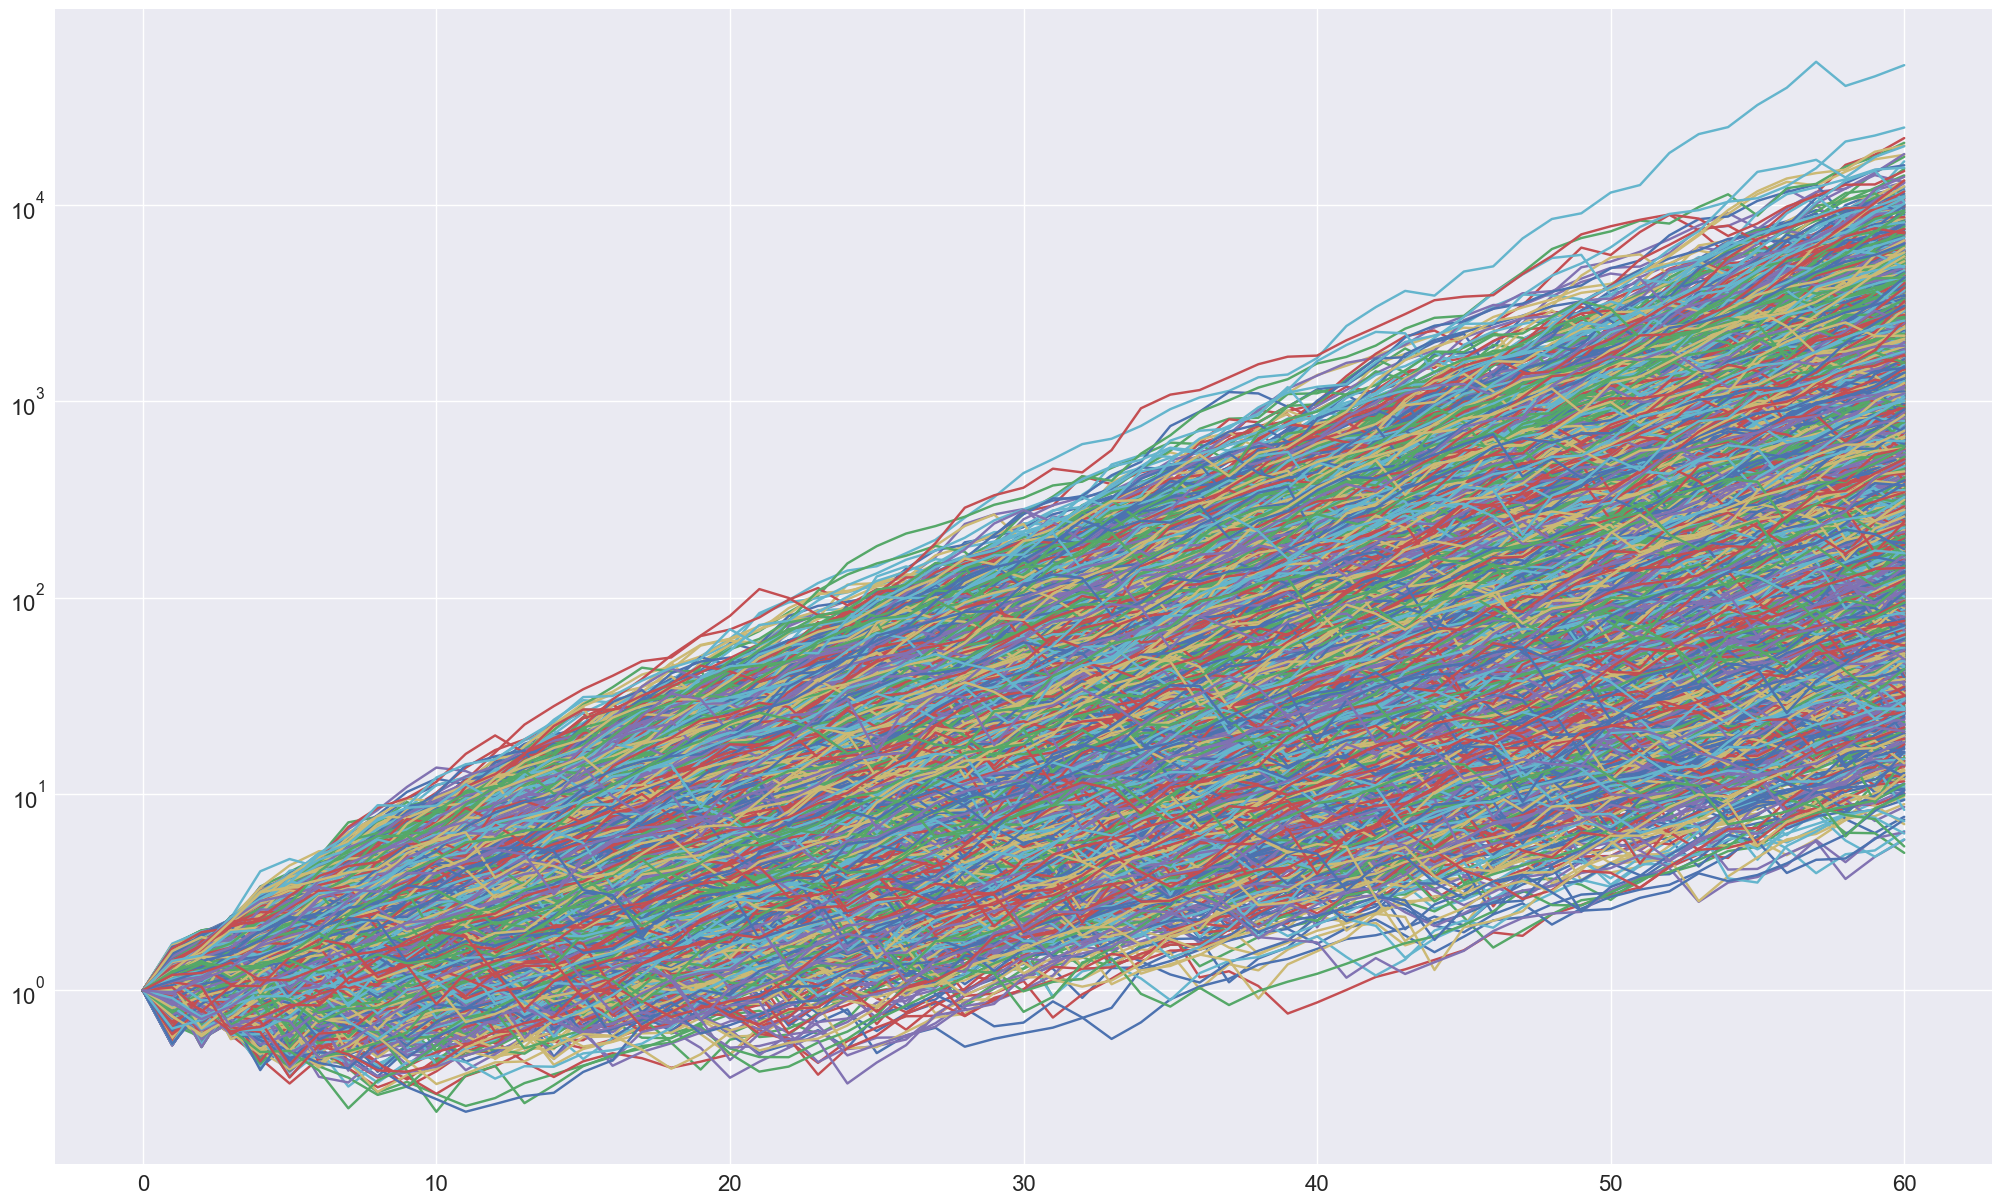

In [22]:
# MONTECARLO COMBINATIONS VISUAL EXTRA SECTION
# Optional: you can visualize the simulations of the investment here
pd.DataFrame(equity_current_interest_factor).plot(legend=None,logy=True,fontsize=16,figsize=(25,15))

## Inflation Data and Simulation Section
This section introduces a series of inflation simulations to evaluate its significant impact on estimated annual withdrawals and the true value of financial amounts over time.
Various simulation methodologies are offered to accommodate different analysis needs:

- **const**: Inflation remains consistent at a predefined average rate, serving as a static parameter throughout the simulation. 3%-4% is recommended.
- **real**: Inflation rates are randomly rescaled from historical data spanning 1954 to 2022, specific to Italy.
- **real rescaled**: Similar to the real method, but adjusted to match a predefined average inflation rate, correcting for historical biases that typically exceed 5%.
- **lognormal**: Inflation rates are modeled using a lognormal distribution, where the mean is set to a predefined rate and the variance is derived from historical inflation data, approximately 0.53.


In [23]:
# INFLATION AND DATA SIMULATION SECTION
# This section introduces a series of inflation simulations to evaluate its significant impact on estimated annual withdrawals and
# the true value of financial amounts over time.
# Various simulation methodologies are offered to accommodate different analysis needs:
#
# - const: Inflation remains consistent at a predefined average rate, serving as a static parameter throughout the simulation.
# 3%-4% is recommended.
# - real: Inflation rates are randomly rescaled from historical data spanning 1954 to 2022, specific to Italy.
# - real rescaled: Similar to the real method, but adjusted to match a predefined average inflation rate, correcting for
# historical biases that typically exceed 5%.
# - lognormal: Inflation rates are modeled using a lognormal distribution, where the mean is set to a predefined rate and
# the variance is derived from historical inflation data, approximately 0.53.

inflation_est_mode = "const"
inflation_est_average_fixed = 0.03
inflation_history = np.array(
    [2.3, 3.4, 1.3, 2.8, -0.4, 2.3, 2.1, 4.7, 7.5, 5.9, 4.6, 2.3, 3.7, 1.4, 2.6, 5.0, 4.8, 5.7, 10.8, 19.1, 17.0, 16.8,
     17.0, 12.1, 14.8, 21.2, 17.8, 16.5, 14.7, 10.8, 9.2, 5.8, 4.8, 5.0, 6.3, 6.5, 6.2, 5.3, 4.7, 4.1, 5.3, 4.0, 2.0,
     2.0, 1.7, 2.5, 2.7, 2.5, 2.7, 2.2, 1.9, 2.1, 1.8, 3.3, 0.8, 1.5, 2.7, 3.0, 1.2, 0.2, 0.1, -0.1, 1.2, 1.2, 0.6,
     -0.2, 1.9, 8.1, 8.7]) / 100
if inflation_est_mode == "const":
    inflation = np.ones((sim_years, simulation_num)) * inflation_est_average_fixed
elif inflation_est_mode == "real":
    inflation = inflation_history[np.random.randint(0, len(inflation_history), (sim_years, simulation_num))]
elif inflation_est_mode == "real rescaled":
    inflation = (inflation_history * (inflation_est_average_fixed / inflation_history.mean()))[
        np.random.randint(0, len(inflation_history), (sim_years, simulation_num))]
elif inflation_est_mode == "lognormal":
    mu = np.log(inflation_est_average_fixed)
    sigma = np.log((1 + np.sqrt(1 + 4 * inflation_history.var() / np.exp(2 * mu))) / 2)
    mu = np.log(inflation_est_average_fixed) - sigma ** 2 / 2
    sigma = np.log((1 + np.sqrt(1 + 4 * inflation_history.var() / np.exp(2 * mu))) / 2)
    mu = np.log(inflation_est_average_fixed) - sigma ** 2 / 2
    inflation = np.random.lognormal(mean=mu, sigma=sigma, size=(sim_years, simulation_num))
else:
    print("Unexpected input.\n"
          "String for inflation not present among the options so average inflation will be used here.")
    inflation = np.ones((sim_years, simulation_num)) * inflation_est_average_fixed
print("Inflation Average:", inflation.mean(), "Inflation Std Dev:", inflation.std())
print("Simulated Inflation History:\n", str(inflation))

Inflation Average: 0.03 Inflation Std Dev: 0.0
Simulated Inflation History:
 [[0.03 0.03 0.03 ... 0.03 0.03 0.03]
 [0.03 0.03 0.03 ... 0.03 0.03 0.03]
 [0.03 0.03 0.03 ... 0.03 0.03 0.03]
 ...
 [0.03 0.03 0.03 ... 0.03 0.03 0.03]
 [0.03 0.03 0.03 ... 0.03 0.03 0.03]
 [0.03 0.03 0.03 ... 0.03 0.03 0.03]]


## Inheritance as an Investment Option Section
This section introduces the possibility of integrating non-liquid assets or not available at the time being, such as potential inheritances, into investment simulations. Real-life unpredictability regarding the timing of such inheritances allows for the simulation to include randomized scenarios. Users can opt to convert existing assets at a pre-determined future date, adjusting their value for inflation—making this particularly relevant for real estate assets.

### Simulation Parameters:
- **random**: Inheritances are adjusted for inflation and received randomly within the simulation timeline.
- **random fixed**: Similar to 'Random', but with a fixed seed to ensure consistent simulation conditions across multiple runs.
- **known**: The timing and amount of the inheritance are predefined, allowing for strategic investment planning.

### Estate Deposit Options:
- **asset**: Immediate investment of inherited assets.
- **buffer**: Placement of assets into a buffer account for liquidity management.

An additional parameter allows for the annual adjustment of the inheritance value to reflect inflation, which is advisable when the assets include real estate.
All annual values are denoted relative to the current year, designated as year zero in the simulation timeline.


In [24]:
# INHERITANCE AS AN INVESTMENT OPTION SECTION
# This section introduces the possibility of integrating non-liquid assets or not available at the time being, such as potential
# inheritances, into investment simulations. Real-life unpredictability regarding the timing of such inheritances allows for the
# simulation to include randomized scenarios. Users can opt to convert existing assets at a pre-determined future date, adjusting
# their value for inflation—making this particularly relevant for real estate assets.
#
# Simulation Parameters:
# - random: Inheritances are adjusted for inflation and received randomly within the simulation timeline.
# - random fixed: Similar to 'Random', but with a fixed seed to ensure consistent simulation conditions across multiple runs.
# - known: The timing and amount of the inheritance are predefined, allowing for strategic investment planning.
#
# Estate Deposit Options:
# - asset: Immediate investment of inherited assets.
# - buffer: Placement of assets into a buffer account for liquidity management.
#
# An additional parameter allows for the annual adjustment of the inheritance value to reflect inflation, which is advisable when
# the assets include real estate.
# All annual values are denoted relative to the current year, designated as year zero in the simulation timeline.

estate = 0
seed_num4rand_pick = 4
rand_pick_min_year = 10
rand_pick_max_year = 60
known_pick_year = 40
estate_pick_mode = "random fixed"
estate_deposit = "buffer"
estate_inflation_correction = True

if estate_pick_mode == "random":
    year_estate2invest_conversion = random.randint(rand_pick_min_year, rand_pick_max_year)
elif estate_pick_mode == "random fixed":
    random.seed(seed_num4rand_pick)
    year_estate2invest_conversion = random.randint(rand_pick_min_year, rand_pick_max_year)
elif estate_pick_mode == "known":
    year_estate2invest_conversion = known_pick_year
else:
    print("Unexpected input.\n"
          "It will be supposed that no inheritance will be obtained in the future nor in a random year neither "
          "in a known moment.")
    year_estate2invest_conversion = 0
    estate = 0

if estate_deposit not in ["asset", "buffer"]:
    print("Unexpected input.\n"
                          "It will be supposed that the inheritance will remain in the buffer account.")

print(f'You will receive your inheritance in {year_estate2invest_conversion} years.')

You will receive your inheritance in 25 years.


## Buffer-Liquidity-BTP and Bond Section
Investment portfolios rarely allocate their entire capital to the stock market. Typically, a portion is kept liquid in bonds, BTPs, or deposit accounts to mitigate the tax implications on withdrawals and provide financial flexibility. This section assumes that the interest on the buffer account equals the inflation rate, and taxes are managed directly from this account.

### Purposes of the Buffer Account
1. **Simplify Financial Transactions:** It eases the management of payments and tax obligations.
2. **Provide Stability in Volatile Markets:** It helps avoid withdrawals from growth-focused accounts during market downturns, preserving long-term investment potential.

### Drawbacks
- **Reduced Long-Term Returns:** Money held in the buffer account usually yields lower returns compared to more aggressive investments, which can significantly impact the financial viability of smaller portfolios.

### Operational Mechanics
- **Annual Adjustment:** The buffer is decreased annually by any associated withdrawal fees and replenished during years of positive returns up to a pre-defined limit.
- **Saturation Point:** This is calculated based on the desired number of years' worth of withdrawals to be covered, for example, setting aside €10,000 annually for 2 years requires €20,000 initially reserved in the buffer.


In [25]:
# BUFFER-LIQUIDITY-BTP and BOND SECTION
# Investment portfolios rarely allocate their entire capital to the stock market. Typically, a portion is kept liquid in bonds, BTPs,
# or deposit accounts to mitigate the tax implications on withdrawals and provide financial flexibility. This section assumes that
# the interest on the buffer account equals the inflation rate, and taxes are managed directly from this account.
#
# Purposes of the Buffer Account
# 1. Simplify Financial Transactions: It eases the management of payments and tax obligations.
# 2. Provide Stability in Volatile Markets: It helps avoid withdrawals from growth-focused accounts during market downturns,
# preserving long-term investment potential.
#
# Drawbacks
# - Reduced Long-Term Returns: Money held in the buffer account usually yields lower returns compared to more aggressive investments,
# which can significantly impact the financial viability of smaller portfolios.
#
# Operational Mechanics
# - Annual Adjustment: The buffer is decreased annually by any associated withdrawal fees and replenished during years of positive
# returns up to a pre-defined limit.
# - Saturation Point: This is calculated based on the desired number of years' worth of withdrawals to be covered, for example,
# setting aside €10,000 annually for 2 years requires €20,000 initially reserved in the buffer.
years_equivalent_equity_buffer = 3

## Taxes and Costs Section
This section outlines the fiscal responsibilities associated with holding financial instruments in Italy:

- **Stamp Duty**: In Italy, all financial instruments are subject to a stamp duty of 2 per mille, calculated based on the reference price of the securities on the last day of the tax period.
- **Capital Gains Tax**: Investments in the stock market are taxed at a rate of 26% on capital gains.
- **Fractional Parameter for Illiquid Assets**: A fractional parameter is available to simulate the initial capital from assets that will be subject to taxation before conversion into liquid investment. For instance, if there is €100K in a bond taxed at 12.5%, the effective initial capital is calculated as €87.5K (i.e., 100 - 12.5% of 100). This parameter is adjustable and optional, set to 1.0 for initial simulations to represent 100% of the capital.

Adjust the aforementioned tax rates according to the financial regulations of your country of residence and chosen financial instrument (1.0 == 100%).


In [26]:
# TAXES AND COSTS SECTION
# This section outlines the fiscal responsibilities associated with holding financial instruments in Italy:
#
# - Stamp Duty: In Italy, all financial instruments are subject to a stamp duty of 2 per mille, calculated based on the reference
# price of the securities on the last day of the tax period.
# - Capital Gains Tax: Investments in the stock market are taxed at a rate of 26% on capital gains.
# - Fractional Parameter for Illiquid Assets: A fractional parameter is available to simulate the initial capital from assets that
# will be subject to taxation before conversion into liquid investment. For instance, if there is €100K in a bond taxed at 12.5%,
# the effective initial capital is calculated as €87.5K (i.e., 100 - 12.5% of 100). This parameter is adjustable and optional, set
# to 1.0 for initial simulations to represent 100% of the capital.
#
# Adjust the aforementioned tax rates according to the financial regulations of your country of residence and chosen financial
# instrument (1.0 == 100%).

stamp_duty = 0.002
inv_tax = 0.26
starting_equity_fraction = 1.0

## Computation Section
This section conducts a Monte Carlo simulation to evaluate the probability of financial survival across various initial capitals, ranging from €0 to €1 million, increased in increments of €50,000. Each year of the simulation is analyzed to determine survival probability based on predefined financial settings.


<Axes: >

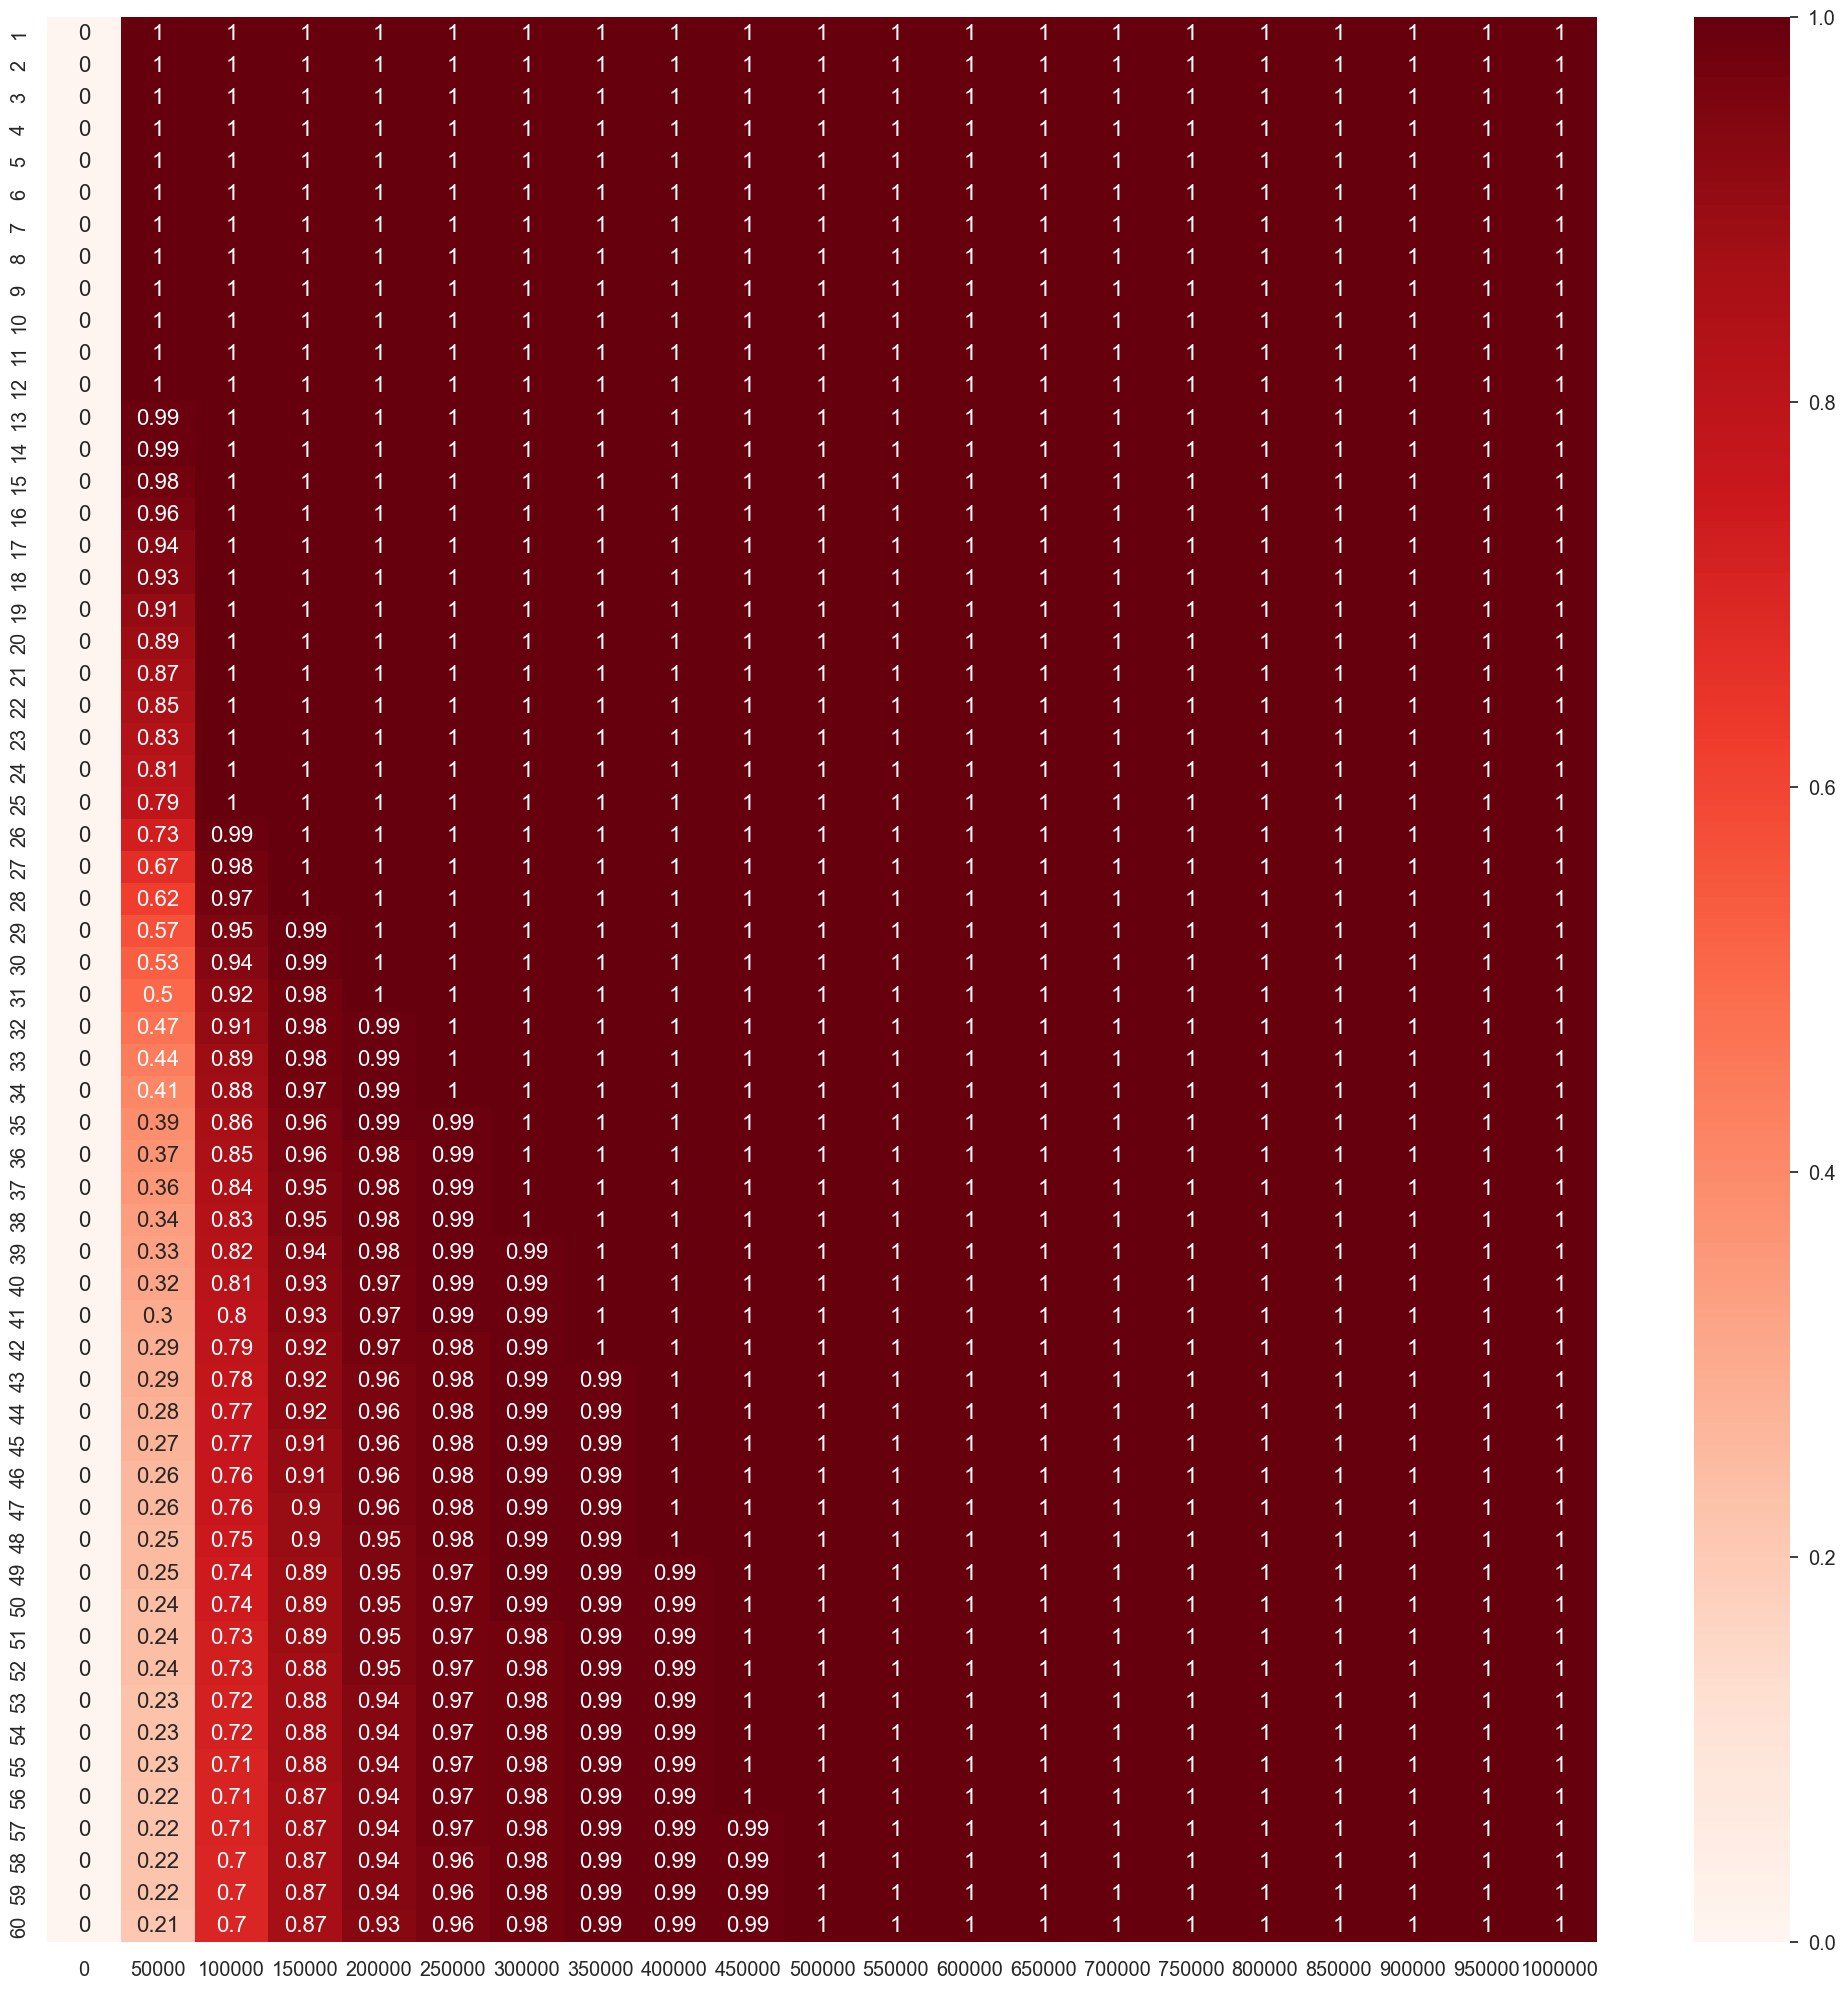

In [27]:
# COMPUTATION SECTION
# This section conducts a Monte Carlo simulation to evaluate the probability of financial survival across various initial capitals,
# ranging from €0 to €1 million, increased in increments of €50,000. Each year of the simulation is analyzed to determine survival
# probability based on predefined financial settings.

def safe_divide(numerator, denominator, _epsilon=1e-6):
    """
    Performs safe division to avoid dividing by zero.
    Replace values of the denominator that are too small with epsilon

    Args:
    numerator (np.array): Array containing the numerators.
    denominator (np.array): Array containing the denominators.
    epsilon (float): A small value to prevent division by zero.

    Returns:
    np.array: Result of the division.
    """
    safe_denominator = np.where(abs(denominator) < _epsilon, np.copysign(_epsilon, denominator), denominator)
    return numerator / safe_denominator

def manage_financials(desired_equity_buffers, actual_equity_buffers, _fire_cum_equities, _withdrawals, _capital_gains, _inv_tax):
    """
    Manages investments and buffers after calculating taxes on the money rearrangement.

    Parameters:
    - _year (int): The current year of the simulation.
    - desired_equity_buffers (numpy.ndarray): 2D array representing the desired buffer states before adjustments.
    - actual_equity_buffers (numpy.ndarray): 2D array representing the actual buffer states after financial operations.
    - _fire_cum_equities (numpy.ndarray): 2D array containing cumulative equities for each year and simulation.
    - _withdrawals (numpy.ndarray): 2D array containing planned withdrawal amounts for each year and simulation.
    - _capital_gains (numpy.ndarray): 1D array containing capital gains for each simulation.
    - _inv_tax (float): Tax rate on investments.
    - _epsilon (float): Threshold value used to avoid division by zero.
    - new_buffers (numpy.ndarray): Precomputed new buffer values for the current year, used to determine withdrawals.

    Returns:
    - actual_equity_buffers (numpy.ndarray): Updated 2D array with financial buffers after withdrawals and taxes.
    - _fire_cum_equities (numpy.ndarray): Updated 2D array with cumulative equities after withdrawals.
    - _capital_gains (numpy.ndarray): Updated 1D array of capital gains after tax application.

    Description:
    The function uses the provided desired equity buffer values to determine the actual amount to withdraw from the investments
    account, ensuring it is not negative. This happens whenever the money needed for withdrawals must be transferred in the
    buffer/cash account:
    - When the asset annual returns are positive
    - When there are not enough money available for withdrawals in the current year
    - When the buffer must be set at the very beginning with the expected withdrawals amount
    It calculates applicable taxes if the withdrawal amount is positive and the savings in the investment account aren't already
    depleted and updates the capital gains by reducing them proportionally based on the taxable amount.
    Finally, updates the investment equities and buffers with net values after withdrawals and taxes.
    """
    withdrawals_amount = np.maximum(0, desired_equity_buffers - actual_equity_buffers)
    _taxes = np.where(_fire_cum_equities * withdrawals_amount > 0,
                     withdrawals_amount * (1 - safe_divide(_capital_gains, _fire_cum_equities)) * _inv_tax,
                     0)
    _capital_gains = np.where(_taxes == 0,
                              _capital_gains,
                              _capital_gains * (1 - safe_divide(withdrawals_amount, _fire_cum_equities)))
    _fire_cum_equities = _fire_cum_equities - withdrawals_amount
    actual_equity_buffers = actual_equity_buffers + withdrawals_amount - _taxes
    return actual_equity_buffers, _fire_cum_equities, _capital_gains



epsilon = 1e-6
starting_equities = list(range(0, 1000001, 50000))
summaryTable = pd.DataFrame(np.zeros((years_job + years_retired, len(starting_equities))),
                            columns=starting_equities,
                            index=list(range(1, sim_years)))

withdrawals = np.zeros((sim_years, simulation_num))
# The first year each month I withdraw what was declared at work
withdrawals[0, :] = withdrawal_job
# Create an array of inflation rates up to `sim_years`, with appropriate padding for the first year
inflation_rates = np.vstack([np.zeros(simulation_num), inflation[:sim_years-1, :]])
# Calculate the compound inflation factor for each year
inflation_compound_interest_factor = np.cumprod(1 + inflation_rates, axis=0)
# Update withdrawals based on compounded inflation
withdrawals[1:years_job+1] = withdrawal_job * inflation_compound_interest_factor[1:years_job+1]
withdrawals[years_job+1:sim_years] = withdrawal_retired *  inflation_compound_interest_factor[years_job+1: sim_years]
if estate_inflation_correction:
    estate_corrected = estate * inflation_compound_interest_factor[1:min(year_estate2invest_conversion + 2, sim_years)]
else:
    estate_corrected = np.ones((min(year_estate2invest_conversion + 2, sim_years), simulation_num)) * estate


for starting_equity in starting_equities:
    buffers = np.zeros((sim_years, simulation_num))
    fire_cum_equities = np.zeros((sim_years, simulation_num))
    capital_gains = np.ones(simulation_num) * starting_equity_fraction * starting_equity

    # Simulate the first year separately due to the initialization of buffers
    year = 0
    fire_cum_equities[0, :] = starting_equity

    # Create the equity buffer based on how many equivalent years of spending I want to have in the buffer account without exceeding the threshold of the maximum
    # initial capital that I am simulating in the current iteration
    # In the first year, I always make withdrawals, so if the years for the equity buffer are set to a value less than 1 by mistake or to put
    # 0, they are set to 1
    # I then simulate that the money is taken from the investment account and taxed for the amount withdrawn in proportion to the capital gains
    # (initially none, but I use the same function always even though the tax calculation in this sense is not needed in the first year so it's as
    # if I created the necessary account for the buffer directly and took the equivalent of the buffer from the investment fund in order to have
    # a total amount equal to the simulation capital)
    new_buffers = np.minimum(fire_cum_equities[year, :] + buffers[year, :],
                             withdrawals[year, :] * max(years_equivalent_equity_buffer, 1))
    buffers[year, :], fire_cum_equities[year, :], capital_gains = manage_financials(
    desired_equity_buffers=new_buffers,
    actual_equity_buffers=buffers[year, :],
    _fire_cum_equities=fire_cum_equities[year, :],
    _withdrawals=withdrawals[year, :],
    _capital_gains=capital_gains,
    _inv_tax=inv_tax
    )
    # The withdrawal is then executed.
    # If there is no need to withdraw because the personal balance is positive, the buffer remains as is and the gain is added to the
    # investments as if it were a systematic investment plan
    # Finally Rounding errors on investment funds that went default are corrected by setting them to 0.
    buffers[year, :] = np.where(withdrawals[year, :] >= 0,
                                buffers[year, :] - withdrawals[year, :],
                                buffers[year, :])
    fire_cum_equities[year, :] = np.where(withdrawals[year, :] >= 0,
                                          fire_cum_equities[year, :],
                                          fire_cum_equities[year, :] - withdrawals[year, :])
    fire_cum_equities[year, :] = np.where(fire_cum_equities[year, :] < withdrawals[year, :] * epsilon, 0,
                          fire_cum_equities[year, :])
    # Simulate the remaining years
    for year in range(1, sim_years):
        # The previous year ends, and the portfolio value is updated based on the simulated returns and losses of the asset
        # The previous year ends, and the value of the buffer is increased in line with inflation as is usual with the interest
        # of a deposit account or conservative bonds
        # Stamp duty is paid
        fire_cum_equities[year, :] = fire_cum_equities[year - 1, :] * equity_compound_interest_factor[year, :]
        buffers[year, :] = buffers[year, :] * (1 + inflation[year, :])
        buffers[year, :] = buffers[year - 1, :] - (fire_cum_equities[year, :] + buffers[year - 1, :]) * stamp_duty
        # The buffer, which may have been reduced by withdrawals in the previous cycle, needs to be replenished
        # This is done only if there were positive returns that were higher than the previous year
        # This caution improves the long-term performance of the portfolio during market crash scenarios
        new_buffers = np.where(equity_current_interest_factor[year, :] > np.maximum(equity_current_interest_factor[year - 1, :], 0),
                              np.minimum(fire_cum_equities[year, :] + buffers[year, :],
                                         withdrawals[year, :] * years_equivalent_equity_buffer),
                                         buffers[year, :])
        buffers[year, :], fire_cum_equities[year, :], capital_gains = manage_financials(
        desired_equity_buffers=new_buffers,
        actual_equity_buffers=buffers[year, :],
        _fire_cum_equities=fire_cum_equities[year, :],
        _withdrawals=withdrawals[year, :],
        _capital_gains=capital_gains,
        _inv_tax=inv_tax
        )
        # Given the stringent conditions with which the buffer is replenished, there can be prolonged lean periods or excessive withdrawals
        # Therefore, the buffer can reduce well beyond the value of equivalent years until it is no longer able to support withdrawals
        # for a single year.
        # In such cases, it is necessary to replenish the buffer for at least one year's withdrawals as long as capital is available.
        new_buffers = np.minimum(fire_cum_equities[year, :] + buffers[year, :], np.maximum(buffers[year, :], withdrawals[year, :]))
        buffers[year, :], fire_cum_equities[year, :], capital_gains = manage_financials(
        desired_equity_buffers=new_buffers,
        actual_equity_buffers=buffers[year, :],
        _fire_cum_equities=fire_cum_equities[year, :],
        _withdrawals=withdrawals[year, :],
        _capital_gains=capital_gains,
        _inv_tax=inv_tax
        )
        # The withdrawal is then executed.
        # If there is no need to withdraw because the personal balance is positive, the buffer remains as is and the gain is added to the
        # investments as if it were a systematic investment plan
        # It is also checked if the current year coincides with the year of conversion of the inheritance into investments.
        # The amount of the inheritance is then added to the buffers after executing the scheduled withdrawal for the year.
        # Otherwise, the normal scheduled withdrawal is performed without additions.
        # In principle, if this were to happen in reality, it would be advisable to put the value of the inheritance directly among the investments
        # with an average interest higher than that of the buffer
        # Finally Rounding errors on investment funds that went default are corrected by setting them to 0.
        if year == year_estate2invest_conversion:
            if estate_deposit == "asset":
                fire_cum_equities[year, :] = fire_cum_equities[year, :] + estate_corrected[year,:]
            elif estate_deposit == "buffer":
                buffers[year, :] = buffers[year, :] + estate_corrected[year,:]
            else:
                buffers[year, :] = buffers[year, :] + estate_corrected[year,:]

        buffers[year, :] = np.where(withdrawals[year, :] >= 0, buffers[year, :] - withdrawals[year, :], buffers[year, :])
        fire_cum_equities[year, :] = np.where(withdrawals[year, :] >= 0, fire_cum_equities[year, :], fire_cum_equities[year, :] - withdrawals[year, :])
        fire_cum_equities[year, :] = np.where(fire_cum_equities[year, :] < withdrawals[year, :] * 1e-6, 0,
                              fire_cum_equities[year, :])

    for sim_year in range(1, sim_years):
        summaryTable.loc[[sim_year], [starting_equity]] = round(((fire_cum_equities[sim_year, :] + buffers[sim_year, :]) >= 0).mean(), 2)

plt.figure(figsize=(25, 25))
seaborn.set(font_scale=1.3)
seaborn.heatmap(summaryTable, cmap="Reds", annot=True, annot_kws={"size": 16})